In [ ]:
%%capture
!pip install torchfile
!pip install facenet-pytorch
!pip install pillow==9.5.0

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms  as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from facenet_pytorch import InceptionResnetV1
import random
from tqdm import tqdm

In [ ]:

class MyDataset(Dataset):
    def __init__(self, list_folder, phase='train', transform=None,return_label = False):
        '''
        phase : 'train' for 85%, 'valid' for 15%,
        '''
        self.return_label = return_label
        ratio_map = {'train': [0, 0.85], 'valid': [0.85, 1]}

        self.index2name = {}
        self.name2index = {}
        self.image_paths = []
        self.labels = []
        self.filterbyperson = {}

        print(f"Scanning phase {phase}!")
        i = 0
        for folder in list_folder:
            for name in os.listdir(folder):



                image_folder = os.path.join(folder, name)
                image_names = os.listdir(image_folder)
                if len(image_names) < 10:
                    continue
                i+=1
                self.index2name[i] = name+str(i)
                self.name2index[name+str(i)] = i

                length = len(image_names)
                begin_ratio, end_ratio = ratio_map[phase]
                begin_index, end_index = int(begin_ratio * length), int(end_ratio * length)

                for image_name in image_names[begin_index:end_index]:
                    image_path = os.path.join(image_folder, image_name)
                    label = self.name2index[name+str(i)]

                    self.image_paths.append(image_path)

                    if label not in self.filterbyperson:
                        self.filterbyperson[label] = [image_path]
                    else:
                        self.filterbyperson[label].append(image_path)

                    self.labels.append([label,len(self.filterbyperson[label])-1])

        if not transform:
            transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((160,160))])
        self.transform = transform

        print(f"Phase {phase} has {len(self.image_paths)} files!")
        print(f"There are {len(self.name2index.keys())} classes.")
        self.num_classes =len(self.name2index.keys())

    def __len__(self):

        return len(self.image_paths)

    def __getitem__(self, i):

        image_path = self.image_paths[i]
        label,index_similar = self.labels[i]


        similar_image_index = random.choice([i for i,_ in enumerate(self.filterbyperson[label]) if i !=index_similar])
        similar_image_path = self.filterbyperson[label][similar_image_index]

        # Get a random image from a different class
        different_label = random.choice([l for l in self.filterbyperson.keys() if l != label])
        different_image_path = random.choice(self.filterbyperson[different_label])

        image = Image.open(image_path)
        similar_image = Image.open(similar_image_path)
        different_image = Image.open(different_image_path)

        image_tensor = self.transform(image)
        similar_image_tensor = self.transform(similar_image)
        different_image_tensor = self.transform(different_image)

        if self.return_label:
            return image_tensor,torch.tensor(label)

        return image_tensor, similar_image_tensor, different_image_tensor


In [ ]:
# convert tensor to rgb image
def tensor2image(tensor,std = 0 , mean  = 255):
    tensor = (tensor)*mean + std
    tensor = tensor.permute(1,2,0)
    return np.array(tensor,dtype = np.uint8)


In [ ]:
img_size = 160
rotation = 15
horizal_flip_p = 0.5
color_augument  = {
    'brightness':0.2,
    'contrast':0.2,
    'saturation':0.2,
    'hue':0.1
}

In [ ]:
list_folder = [r'/kaggle/input/vietnamese-celebrity-faces/Ca sĩ',r'/kaggle/input/vietnamese-celebrity-faces/Hoa hậu']

data_parameters = {
    'batch_size' : 64,
     'shuffle'   : True
}

train_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(p=horizal_flip_p),  # Always flip horizontally
    transforms.ColorJitter(**color_augument),  # Color augmentation
    transforms.RandomRotation(degrees=rotation),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])

train_dataset = MyDataset(list_folder,
                          phase = 'train',
                          transform = train_transform)
valid_dataset = MyDataset(list_folder = list_folder,
                          phase = 'valid')

train_dataloader = DataLoader(train_dataset,**data_parameters)
valid_dataloader = DataLoader(valid_dataset,**data_parameters)


Scanning phase train!
Phase train has 3883 files!
There are 116 classes.
Scanning phase valid!
Phase valid has 751 files!
There are 116 classes.
Scanning phase test!
Phase test has 522 files!
There are 116 classes.


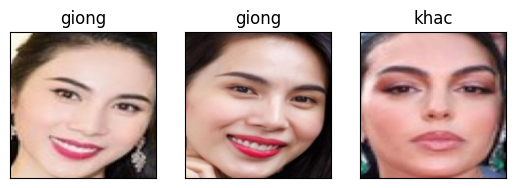

In [ ]:
name2dataset = {
    'train': train_dataset,
    'valid': valid_dataset
}


dataset_name = random.choice(['train','valid'])
dataset = name2dataset[dataset_name]
index = random.randint(0,len(dataset)-1)

image,image_similar,image_not_similar = dataset[index]
image_list = tensor2image(image),tensor2image(image_similar),tensor2image(image_not_similar)
titles = ['giong','giong','khac']
for i,image in enumerate(image_list):
    plt.subplot(1,3,i+1)
    plt.yticks([])
    plt.xticks([])
    plt.title(titles[i])
    plt.imshow(image)

In [ ]:
model = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:

for name,module in model.named_children():
    if 'last' in name or 'block8' in name:
        print(f"Module {name} turn on during training")
        for param in module.parameters():
            param.requires_grad  = True
    else:
        for param in module.parameters():
            param.requires_grad = False
        print(f"Module {name} turn off during training")
model.train()
optimizer = optim.Adam( [parameter for parameter in model.parameters() if parameter.requires_grad == True], lr=0.004)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)


Module conv2d_1a turn off during training
Module conv2d_2a turn off during training
Module conv2d_2b turn off during training
Module maxpool_3a turn off during training
Module conv2d_3b turn off during training
Module conv2d_4a turn off during training
Module conv2d_4b turn off during training
Module repeat_1 turn off during training
Module mixed_6a turn off during training
Module repeat_2 turn off during training
Module mixed_7a turn off during training
Module repeat_3 turn off during training
Module block8 turn on during training
Module avgpool_1a turn off during training
Module dropout turn off during training
Module last_linear turn on during training
Module last_bn turn on during training
Module logits turn off during training


In [ ]:
epochs = 50
criterion = nn.TripletMarginLoss(margin = 0.25)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(f'Start training on {device}!')

dataloader_map = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

train_loss = []
valid_loss = []
best_valid_loss = float('inf')  # Initialize with infinity
lr = optimizer.param_groups[0]["lr"]

for epoch in range(epochs):

    for phase in ['train', 'valid']:
        dataloader = dataloader_map[phase]


        if phase == 'train':
            model.train()
            with tqdm(dataloader, desc=f"{epoch}/{epochs}, Lr : {lr}") as process_bar:
                for image, similar_image, different_image in process_bar:
                    inputs = torch.cat([image, similar_image, different_image], dim=0).to(device)

                    optimizer.zero_grad()  # Zero the parameter gradients
                    probs = model(inputs)
                    loss = criterion(*(probs.chunk(3)))  # Compute loss
                    loss.backward()  # Backward pass
                    optimizer.step()

                    process_bar.set_postfix({'Loss': loss.item()})
            torch.save(model.state_dict(), "last.pt")
            if (epoch+1) %15 == 0:
                lr_scheduler.step()
        elif phase == 'valid':
            model.eval()
            with torch.no_grad():
                last_valid_loss = 0
                for idx, (image, similar_image, different_image) in enumerate(dataloader):
                    inputs = torch.cat([image, similar_image, different_image], dim=0).to(device)
                    probs = model(inputs)
                    loss = criterion(*(probs.chunk(3)))  # Compute loss
                    last_valid_loss += loss.item()
                last_valid_loss /= len(dataloader)
                valid_loss.append(last_valid_loss)
                print(f"Valid loss {last_valid_loss}")
                if last_valid_loss < best_valid_loss:
                    best_valid_loss = last_valid_loss
                    torch.save(model.state_dict(), 'best.pt')



Start training on cuda!


0/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it, Loss=0.00999]


Valid loss 0.05988106969743967


1/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.0127] 


Valid loss 0.056572806710998215


2/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.0181] 


Valid loss 0.051607394901414715


3/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.0242] 


Valid loss 0.0486795911565423


4/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.00701]


Valid loss 0.05000315854946772


5/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it, Loss=0.0089]  


Valid loss 0.06123464492460092


6/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.0101] 


Valid loss 0.0595063044068714


7/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it, Loss=0.0188] 


Valid loss 0.05566185154020786


8/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it, Loss=0.0125]  


Valid loss 0.06968724479277928


9/50, Lr : 0.002: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it, Loss=0.00803]


Valid loss 0.05931296184038123


10/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it, Loss=0.0386] 


Valid loss 0.04788012709468603


11/50, Lr : 0.002: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it, Loss=0.0189] 


Valid loss 0.06342724865923326


12/50, Lr : 0.002:  84%|████████▎ | 51/61 [00:54<00:10,  1.08s/it, Loss=0.0196] 


KeyboardInterrupt: 

In [ ]:
!gdown --id 1sUKrX8bGaT0L4dt9V1rBS6r9M3JbfRRr

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sUKrX8bGaT0L4dt9V1rBS6r9M3JbfRRr
From (redirected): https://drive.google.com/uc?id=1sUKrX8bGaT0L4dt9V1rBS6r9M3JbfRRr&confirm=t&uuid=24281527-3705-4bfc-9bbc-8003a3277f67
To: /content/best _inception.pt
100% 112M/112M [00:03<00:00, 30.3MB/s]


In [ ]:
device = torch.cuda.is_available()
model = InceptionResnetV1(pretrained='vggface2')
state_dict = torch.load("best.pt")
model.load_state_dict(state_dict)
model.eval().to(device)

In [ ]:
with torch.no_grad():
    last_valid_loss = 0
    for idx, (image, similar_image, different_image) in enumerate(dataloader):
        inputs = torch.cat([image, similar_image, different_image], dim=0).to(device)
        probs = model(inputs)
        loss = criterion(*(probs.chunk(3)))  # Compute loss
        last_valid_loss += loss.item()
    last_valid_loss /= len(dataloader)
    valid_loss.append(last_valid_loss)
    print(f"Valid loss {last_valid_loss}")
    if last_valid_loss < best_valid_loss:
        best_valid_loss = last_valid_loss

Valid loss 0.012719566651360422


In [ ]:
model.eval()
total = 0
total_accuracy = 0
with torch.no_grad():
    for i, (image,similar_image,different_image) in enumerate(valid_dataloader):
                    batch = image.shape[0]
                    inputs = torch.cat([image,similar_image,different_image],dim = 0).to(device)
                    prob = model(inputs)
                    emb1,emb2,emb3 = prob.chunk(3)
                    total_accuracy += torch.sum(torch.norm(emb2-emb3,dim = 1,p = 2) > 0.95).item()
                    total_accuracy += torch.sum(torch.norm(emb2-emb1,dim = 1,p = 2) < 0.95).item()
                    total +=batch * 2
print(f"Accuracy {total_accuracy/total}")

Accuracy 0.8268974700399467


In [ ]:
def distance(emb1, emb2, thresh = 0.85):
    emb1 = emb1.squeeze()
    emb2 = emb2.squeeze()
    assert(emb1.shape[0] == 512 and len(emb1.shape) ==1 )

    return torch.norm(emb2-emb1,dim = 0,p = 2).item()

Text(0.5, 1.0, 'Predict : 1.53')

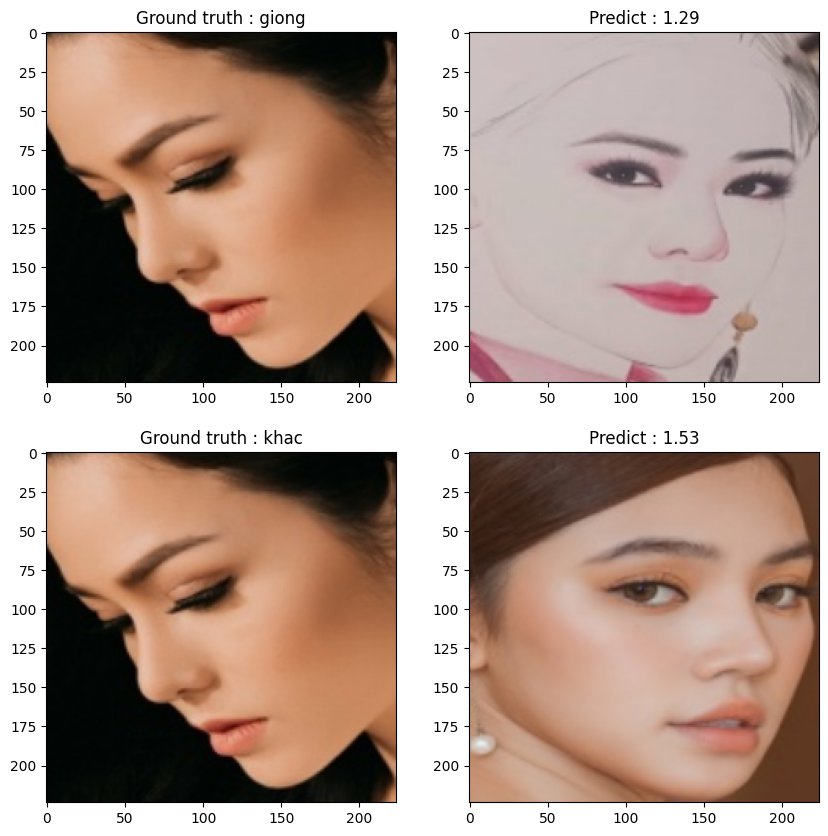

In [ ]:
index = random.choice(range(12))
with torch.no_grad():
    for i, (image,similar_image,different_image) in enumerate(valid_dataloader):
        if  i == index:
                    batch = image.shape[0]
                    inputs = torch.cat([image,similar_image,different_image],dim = 0).to(device)
                    prob = model(inputs)
                    emb1,emb2,emb3 = prob.chunk(3)
                    break
image_index =random.choice(range(batch))
image = tensor2image(image[image_index])
similar_image = tensor2image(similar_image[image_index])
different_image = tensor2image(different_image[image_index])
emb1 = emb1[image_index]
emb2 = emb2[image_index]
emb3 = emb3[image_index]
result1 =  'giong' if round(distance(emb1,emb2),2) < 0.9 else 'khac'
result2 =  'giong' if round(distance(emb1,emb2),2) < 0.9 else 'khac'
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(image)
plt.title(f"Ground truth : giong")
plt.subplot(2,2,2)
plt.imshow(similar_image)
plt.title(f"Predict : {result1}")
plt.subplot(2,2,3)
plt.imshow(image)
plt.title(f"Ground truth : khac")
plt.subplot(2,2,4)
plt.imshow(different_image)
plt.title(f"Predict : {result2}")


In [ ]:
def distance_all(emb,emb2):
    assert(emb.shape[0]!=1 and len(emb.shape)==2 and len(emb2.shape)==1)
    return torch.norm(emb-emb2,p = 2,dim = 1).cpu()


In [ ]:
from tqdm import tqdm
def get_embed(model,dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataloader.dataset.return_label = True
    model.eval()
    model.to(device)
    all_emb = []
    labels_all = []
    process_bar = tqdm(dataloader,total = len(dataloader))
    with torch.no_grad():
        for images,labels in  process_bar:
            emb  =  model(images.to(device))
            all_emb.append(emb)
            for i in range(labels.shape[0]):
                labels_all.append(labels[i].item())
    dataloader.dataset.return_label = False
    return torch.cat(all_emb,0),labels_all
emb_all,label_all = get_embed(model,valid_dataloader)



100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


In [ ]:
from collections import Counter
def get_label(emb_all,label_all,emb1, thresold = 0.9,topk = 10,min_appear = 2):
    distance_a = distance_all(emb_all,emb1)
    data = list(zip(distance_a,label_all))
    data = [(value[0].item() ,value[1]) for value in data if value[0] < thresold]
    data = sorted(data,key = lambda x: x[0])[:topk]
    data = [value[1] for value in data]
    index = [value[0] for value in Counter(data).most_common()[0:2] if value[1] >= min_appear]
    return index


[51, 105]

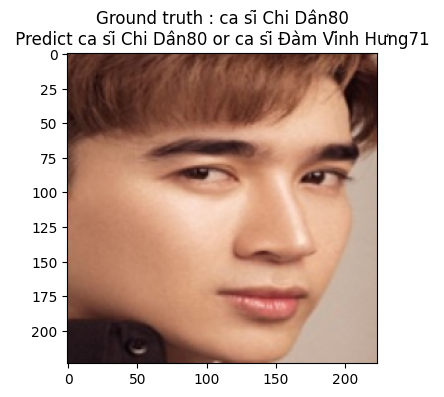

In [ ]:
index = random.choice(range(12))
valid_dataloader.dataset.return_label = True
with torch.no_grad():
    for i, (image,label) in enumerate(valid_dataloader):
        if  i == index:
                    batch = image.shape[0]
                    inputs = image.to(device)
                    prob = model(inputs)
                    emb1= prob
                    break
image_index =random.choice(range(batch))

image = tensor2image(image[image_index])
label = label[image_index]
name = valid_dataloader.dataset.index2name[label.item()]

emb1 = emb1[image_index]

plt.figure(figsize = (4,10))
plt.imshow(image)
indices = get_label(emb_all,label_all,emb1)
title  = f"Ground truth : {name}\n Predict "
for i,index in enumerate(indices):
    name = valid_dataloader.dataset.index2name[index]
    title +=f"{name} "
    if i <= len(indices)-2:
        title +='or '

plt.title(title)
valid_dataloader.dataset.return_label = False




In [ ]:
import torch
from facenet_pytorch import InceptionResnetV1

# Tải mô hình đã được huấn luyện trên vggface2
model = InceptionResnetV1(pretrained='vggface2').eval()

# Nếu bạn đã lưu trọng số sau khi huấn luyện
state_dict = torch.load("/content/best _inception.pt")
model.load_state_dict(state_dict)

# Chuyển mô hình sang chế độ đánh giá
model.eval()


  0%|          | 0.00/107M [00:00<?, ?B/s]

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
import pickle
with open('/content/data.pkl', 'rb') as f:
    emb_all = pickle.load(f)
    labels_all = pickle.load(f)
    index_to_name = pickle.load(f)


In [ ]:
print(index_to_name)

{1: 'ca sĩ Trương Kiệt1', 2: 'ca sĩ Thiều Bảo Trâm2', 3: 'ca sĩ Dương Triệu Vũ3', 4: 'ca sĩ Mr. Siro4', 5: 'ca sĩ Jang Mi5', 6: 'ca sĩ Don Nguyễn6', 7: 'ca sĩ Minh Tuyết7', 8: 'ca sĩ Luna Đào8', 9: 'ca sĩ Akira Phan9', 10: 'ca sĩ Kyo York10', 11: 'ca sĩ Gin Tuấn Kiệt11', 12: 'ca sĩ Ngô Kiến Huy12', 13: 'ca sĩ Khởi My13', 14: 'ca sĩ Bích Phương14', 15: 'ca sĩ Khánh Phương15', 16: 'ca sĩ Soobin Hoàng Sơn16', 17: 'ca sĩ Min17', 18: 'ca sĩ Hồ Quang Hiếu18', 19: 'ca sĩ Hari Won19', 20: 'ca sĩ Đinh Duy Chinh20', 21: 'ca sĩ Trương Thế Vinh21', 22: 'ca sĩ Tiết Chi Khiêm22', 23: 'ca sĩ Thuỷ Tiên23', 24: 'ca sĩ Hiền Thục24', 25: 'ca sĩ Sơn Tùng25', 26: 'ca sĩ K Icm26', 27: 'ca sĩ Trịnh Thăng Bình27', 28: 'ca sĩ Fanny Trần28', 29: 'ca sĩ Trương Quỳnh Anh29', 30: 'ca sĩ Bảo Thy30', 31: 'ca sĩ Như Quỳnh31', 32: 'ca sĩ Lynk Lee32', 33: 'ca sĩ Thu Minh33', 34: 'ca sĩ Ông Cao Thắng34', 35: 'ca sĩ Lưo

The predicted label for the image is: ca sĩ Bùi Anh Tuấn41


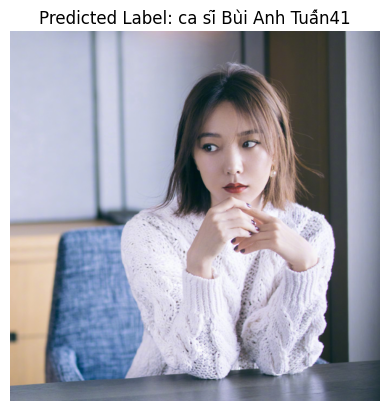

In [ ]:
import pickle
import torch
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
import matplotlib.pyplot as plt

with open('/content/data.pkl', 'rb') as f:
    emb_all = pickle.load(f)
    labels_all = pickle.load(f)
    index_to_name = pickle.load(f)

model_path = '/content/best _inception.pt'
image_path = '/content/XX.png'

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2')
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

emb_all = emb_all.to(device)

def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor.to(device), image

def get_embedding(image_tensor):
    with torch.no_grad():
        embedding = model(image_tensor)
    return embedding
def find_label_name(emb, emb_all, labels_all, index_to_name):
    distances = torch.norm(emb_all - emb, dim=1, p=2)
    min_distance_index = torch.argmin(distances)
    label_index = labels_all[min_distance_index]
    return index_to_name[label_index]
new_image_tensor, original_image = preprocess_image(image_path)
new_image_embedding = get_embedding(new_image_tensor)

predicted_label_name = find_label_name(new_image_embedding, emb_all, labels_all, index_to_name)
print(f'The predicted label for the image is: {predicted_label_name}')

plt.imshow(original_image)
plt.title(f'Predicted Label: {predicted_label_name}')
plt.axis('off')
plt.show()


In [ ]:
!pip install dlib
!kaggle datasets download -d sergiovirahonda/shape-predictor-68-face-landmarksdat

Dataset URL: https://www.kaggle.com/datasets/sergiovirahonda/shape-predictor-68-face-landmarksdat
License(s): unknown
 82% 57.0M/69.3M [00:00<00:00, 97.0MB/s]
100% 69.3M/69.3M [00:00<00:00, 92.7MB/s]


In [ ]:
!pip install scikit-image

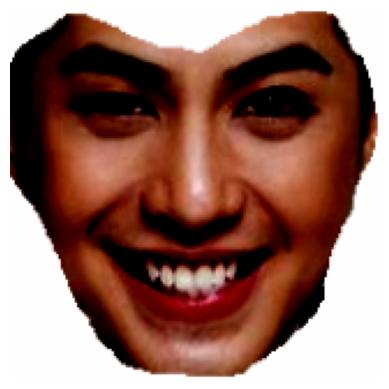

The predicted labels and their probabilities are:
ca sĩ Noo Phước Thịnh43: 40.00%
ca sĩ Karik42: 30.00%


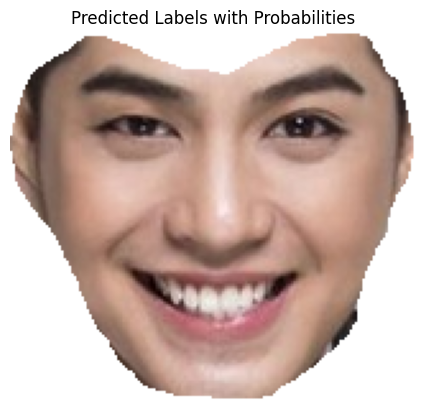

In [ ]:
import pickle
import torch
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load embeddings, labels, and the index-to-name mapping
with open('/content/data.pkl', 'rb') as f:
    emb_all = pickle.load(f)
    labels_all = pickle.load(f)
    index_to_name = pickle.load(f)

# Define paths and load the model
model_path = '/content/best _inception.pt'
image_path = '/content/kldk.PNG'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load face detection and recognition models
mtcnn = MTCNN(keep_all=True, device=device)
model = InceptionResnetV1(pretrained='vggface2')
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

# Ensure embeddings are on the same device
emb_all = emb_all.to(device)

def preprocess_and_align(image_path):
    image = Image.open(image_path).convert('RGB')
    faces, probs, points = mtcnn.detect(image, landmarks=True)
    if faces is None:
        return None, image  # No faces detected, return the original image for display

    # Extract the first detected face (assuming the first is the most confident one)
    face = mtcnn.extract(image, faces, save_path=None)[0]
    return face, image

def get_embedding(face_tensor):
    if face_tensor.ndim == 3:
        face_tensor = face_tensor.unsqueeze(0)  # Add batch dimension if missing
    face_tensor = face_tensor.to(device)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding

def get_label(emb_all, label_all, emb1, threshold=0.9, topk=10, min_appear=2):
    distances = torch.norm(emb_all - emb1, dim=1, p=2)
    filtered_data = [(dist.item(), label) for dist, label in zip(distances, label_all) if dist < threshold]
    sorted_data = sorted(filtered_data, key=lambda x: x[0])[:topk]
    labels = [label for _, label in sorted_data]
    label_counts = Counter(labels)
    total_counts = sum(label_counts.values())
    label_probabilities = {index_to_name[label]: (count / total_counts) * 100 for label, count in label_counts.items() if count >= min_appear}
    return label_probabilities

# Process image, detect and align face
face, original_image = preprocess_and_align(image_path)

if face is None:
    print("No face detected in the image.")
else:
    # Display the processed face
    face_display = face.permute(1, 2, 0).cpu().numpy()
    plt.imshow(face_display)
    plt.axis('off')
    plt.show()

    # Get embedding and predict label probabilities
    face_embedding = get_embedding(face)
    predicted_label_probabilities = get_label(emb_all, labels_all, face_embedding)
    print("The predicted labels and their probabilities are:")
    for label, probability in predicted_label_probabilities.items():
        print(f"{label}: {probability:.2f}%")

    # Show original image with predicted labels
    plt.imshow(np.array(original_image))
    plt.title('Predicted Labels with Probabilities')
    plt.axis('off')
    plt.show()


In [ ]:
!gdown --id 1DoenbnSFbT36cVRLgNHScwTtf8U6bAi0

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DoenbnSFbT36cVRLgNHScwTtf8U6bAi0
To: /content/test.zip
100% 646k/646k [00:00<00:00, 7.52MB/s]


In [ ]:
!unzip /content/test.zip

Archive:  /content/test.zip
   creating: test/
 extracting: test/04f07741-0f9e-4447-a6dc-81a774ac68f6.png  
  inflating: test/cccc.jfif          
 extracting: test/flkf.PNG           
 extracting: test/kkj.PNG            
 extracting: test/kkk.PNG            
 extracting: test/krk.PNG            
 extracting: test/ldf.PNG            
  inflating: test/sss.jpg            


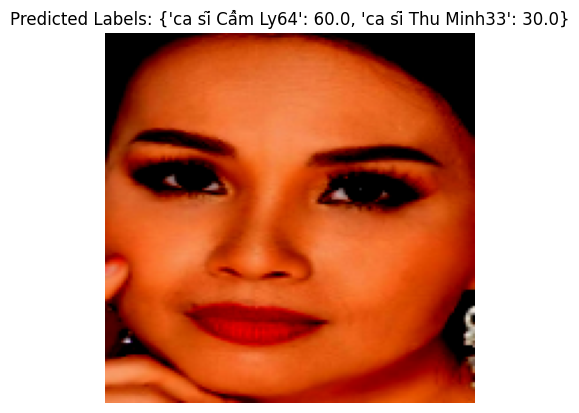

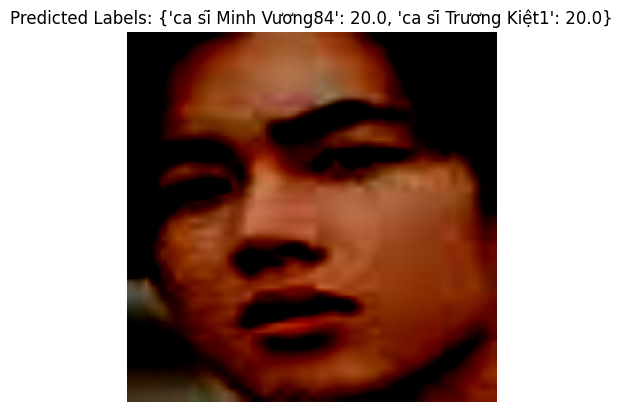

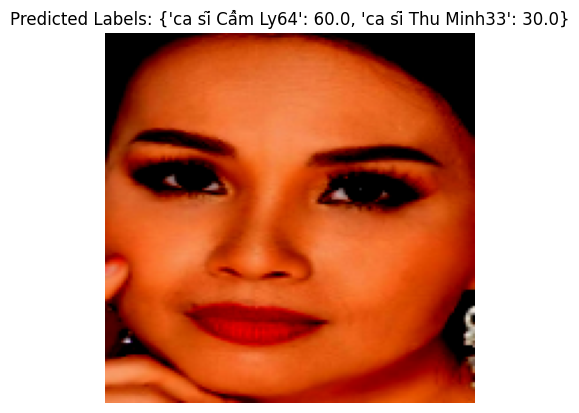

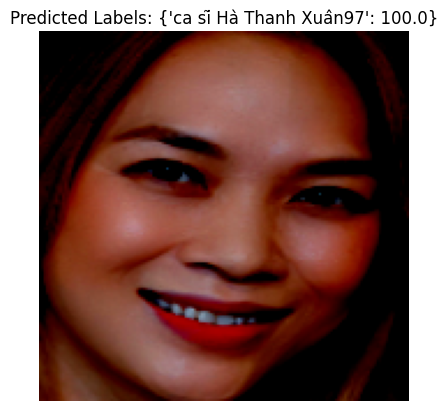

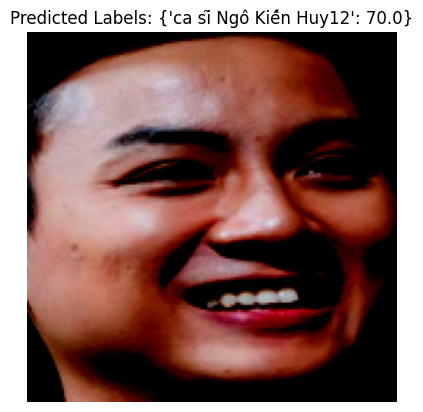

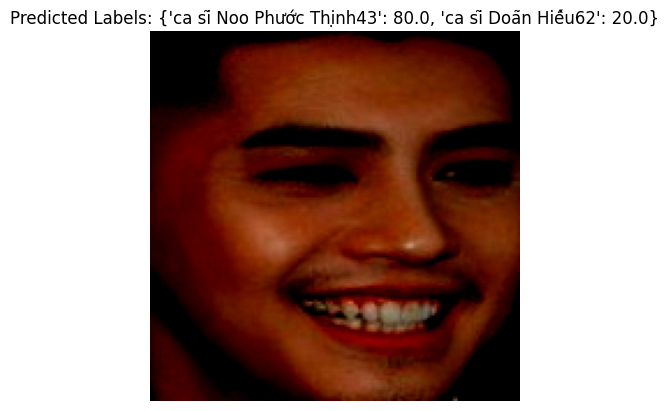

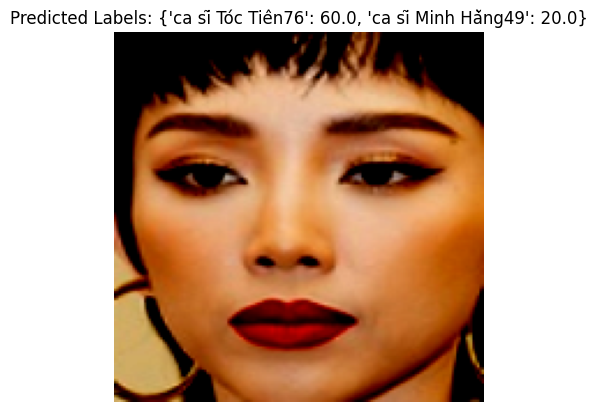

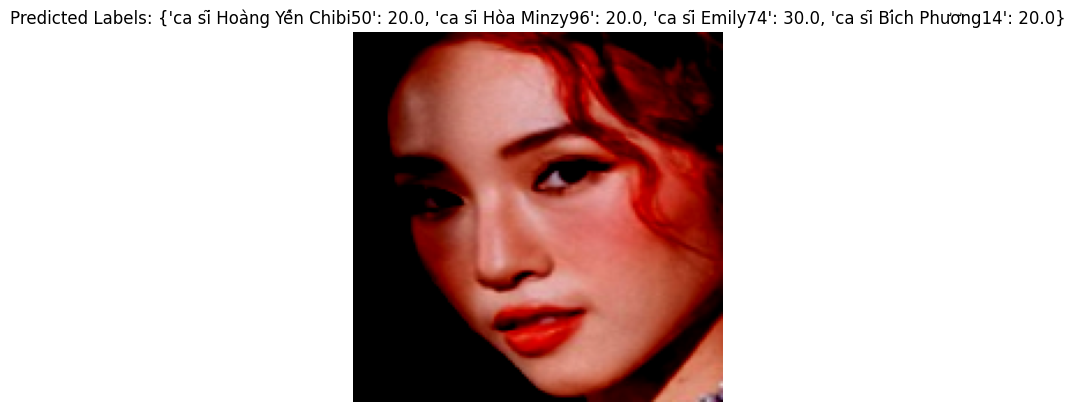

In [ ]:
import os
import pickle
import torch
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load embeddings, labels, and the index-to-name mapping
with open('/content/data.pkl', 'rb') as f:
    emb_all = pickle.load(f)
    labels_all = pickle.load(f)
    index_to_name = pickle.load(f)

# Define paths and load the model
model_path = '/content/best _inception.pt'
test_folder = '/content/test'  # Folder containing all test images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load face detection and recognition models
mtcnn = MTCNN(keep_all=True, device=device)
model = InceptionResnetV1(pretrained='vggface2')
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

# Ensure embeddings are on the same device
emb_all = emb_all.to(device)

def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    face, _ = preprocess_and_align(image)
    if face is None:
        print(f"No face detected in: {image_path}")
        return None, None
    face_embedding = get_embedding(face)
    predicted_label_probabilities = get_label(emb_all, labels_all, face_embedding)
    return face, predicted_label_probabilities

def preprocess_and_align(image):
    faces, probs, points = mtcnn.detect(image, landmarks=True)
    if faces is None:
        return None, image  # No faces detected, return the original image for display
    face = mtcnn.extract(image, faces, save_path=None)[0]
    return face, image

def get_embedding(face_tensor):
    if face_tensor.ndim == 3:
        face_tensor = face_tensor.unsqueeze(0)
    face_tensor = face_tensor.to(device)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding

def get_label(emb_all, label_all, emb1, threshold=0.9, topk=10, min_appear=2):
    distances = torch.norm(emb_all - emb1, dim=1, p=2)
    filtered_data = [(dist.item(), label) for dist, label in zip(distances, label_all) if dist < threshold]
    sorted_data = sorted(filtered_data, key=lambda x: x[0])[:topk]
    labels = [label for _, label in sorted_data]
    label_counts = Counter(labels)
    total_counts = sum(label_counts.values())
    label_probabilities = {index_to_name[label]: (count / total_counts) * 100 for label, count in label_counts.items() if count >= min_appear}
    return label_probabilities

# Iterate through each image in the folder
for filename in os.listdir(test_folder):
    image_path = os.path.join(test_folder, filename)
    face, predicted_label_probabilities = process_image(image_path)
    if face is not None:
        # Display the processed face and predicted labels
        plt.imshow(face.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Predicted Labels: {predicted_label_probabilities}')
        plt.axis('off')
        plt.show()

# Note: You may want to adjust how results are displayed depending on the number of images and desired output format.


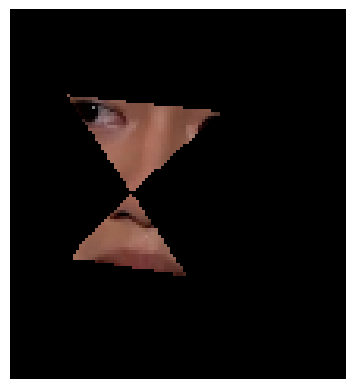

The predicted labels and their probabilities are:
ca sĩ Karik42: 30.00%
ca sĩ S.T Sơn Thạch79: 40.00%
ca sĩ Dịch Dương Thiên Tỉ73: 20.00%


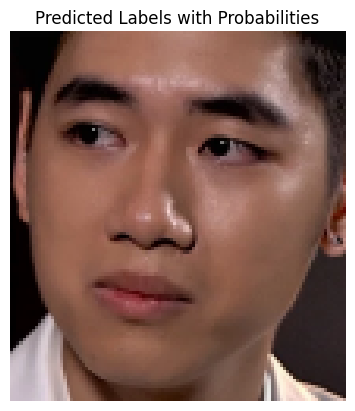

In [ ]:
import os
import pickle
import torch
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage.draw import polygon

# Load embeddings, labels, and the index-to-name mapping
with open('/content/data.pkl', 'rb') as f:
    emb_all = pickle.load(f)
    labels_all = pickle.load(f)
    index_to_name = pickle.load(f)

# Define paths and load the model
model_path = '/content/best _inception.pt'  # Ensure no extra spaces in the filename
image_path = '/content/dfff.PNG'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load face detection and recognition models
mtcnn = MTCNN(keep_all=True, device=device)
model = InceptionResnetV1(pretrained='vggface2')
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

# Ensure embeddings are on the same device
emb_all = emb_all.to(device)

def preprocess_and_align(image_path):
    image = Image.open(image_path).convert('RGB')
    np_image = np.array(image)  # Convert PIL Image to a NumPy array
    faces, probs, points = mtcnn.detect(image, landmarks=True)
    if faces is None or points is None or len(faces) == 0 or len(points) == 0:
        return None, image  # No faces detected, return the original image for display

    # Extract the first detected face using the most confident points
    rr, cc = polygon(points[0][:,1], points[0][:,0], np_image.shape[:2])
    mask = np.zeros(np_image.shape[:2], dtype=np.uint8)
    mask[rr, cc] = 1
    masked_face = np_image * mask[:, :, np.newaxis]
    face_image = Image.fromarray(masked_face)  # Convert back to PIL Image

    return face_image, image

def get_embedding(face_tensor):
    if face_tensor.ndim == 3:
        face_tensor = face_tensor.unsqueeze(0)  # Add batch dimension if missing
    face_tensor = face_tensor.to(device)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding

def get_label(emb_all, label_all, emb1, threshold=0.9, topk=10, min_appear=2):
    distances = torch.norm(emb_all - emb1, dim=1, p=2)
    filtered_data = [(dist.item(), label) for dist, label in zip(distances, label_all) if dist < threshold]
    sorted_data = sorted(filtered_data, key=lambda x: x[0])[:topk]
    labels = [label for _, label in sorted_data]
    label_counts = Counter(labels)
    total_counts = sum(label_counts.values())
    label_probabilities = {index_to_name[label]: (count / total_counts) * 100 for label, count in label_counts.items() if count >= min_appear}
    return label_probabilities

# Process image, detect and align face
face, original_image = preprocess_and_align(image_path)

if face is None:
    print("No face detected in the image.")
else:
    # Display the processed face
    plt.imshow(face)
    plt.axis('off')
    plt.show()

    # Convert face to tensor, get embedding, and predict label probabilities
    face_tensor = transforms.ToTensor()(face)
    face_embedding = get_embedding(face_tensor)
    predicted_label_probabilities = get_label(emb_all, labels_all, face_embedding)
    print("The predicted labels and their probabilities are:")
    for label, probability in predicted_label_probabilities.items():
        print(f"{label}: {probability:.2f}%")

    # Show original image with predicted labels
    plt.imshow(np.array(original_image))
    plt.title('Predicted Labels with Probabilities')
    plt.axis('off')
    plt.show()
